## Imports

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Create Heatmap Displays

PHQ8_NoInterest:
  Absolute Average Difference: 0.343
  Number of N/A Questions: 67
  Accuracy on Available Questions: 0.886
  Overall Accuracy: 0.304
--------------------------------------------------
PHQ8_Depressed:
  Absolute Average Difference: 0.608
  Number of N/A Questions: 23
  Accuracy on Available Questions: 0.797
  Overall Accuracy: 0.618
--------------------------------------------------
PHQ8_Sleep:
  Absolute Average Difference: 0.670
  Number of N/A Questions: 2
  Accuracy on Available Questions: 0.777
  Overall Accuracy: 0.761
--------------------------------------------------
PHQ8_Tired:
  Absolute Average Difference: 0.735
  Number of N/A Questions: 34
  Accuracy on Available Questions: 0.755
  Overall Accuracy: 0.503
--------------------------------------------------
PHQ8_Appetite:
  Absolute Average Difference: 0.500
  Number of N/A Questions: 90
  Accuracy on Available Questions: 0.833
  Overall Accuracy: 0.098
--------------------------------------------------
PHQ8

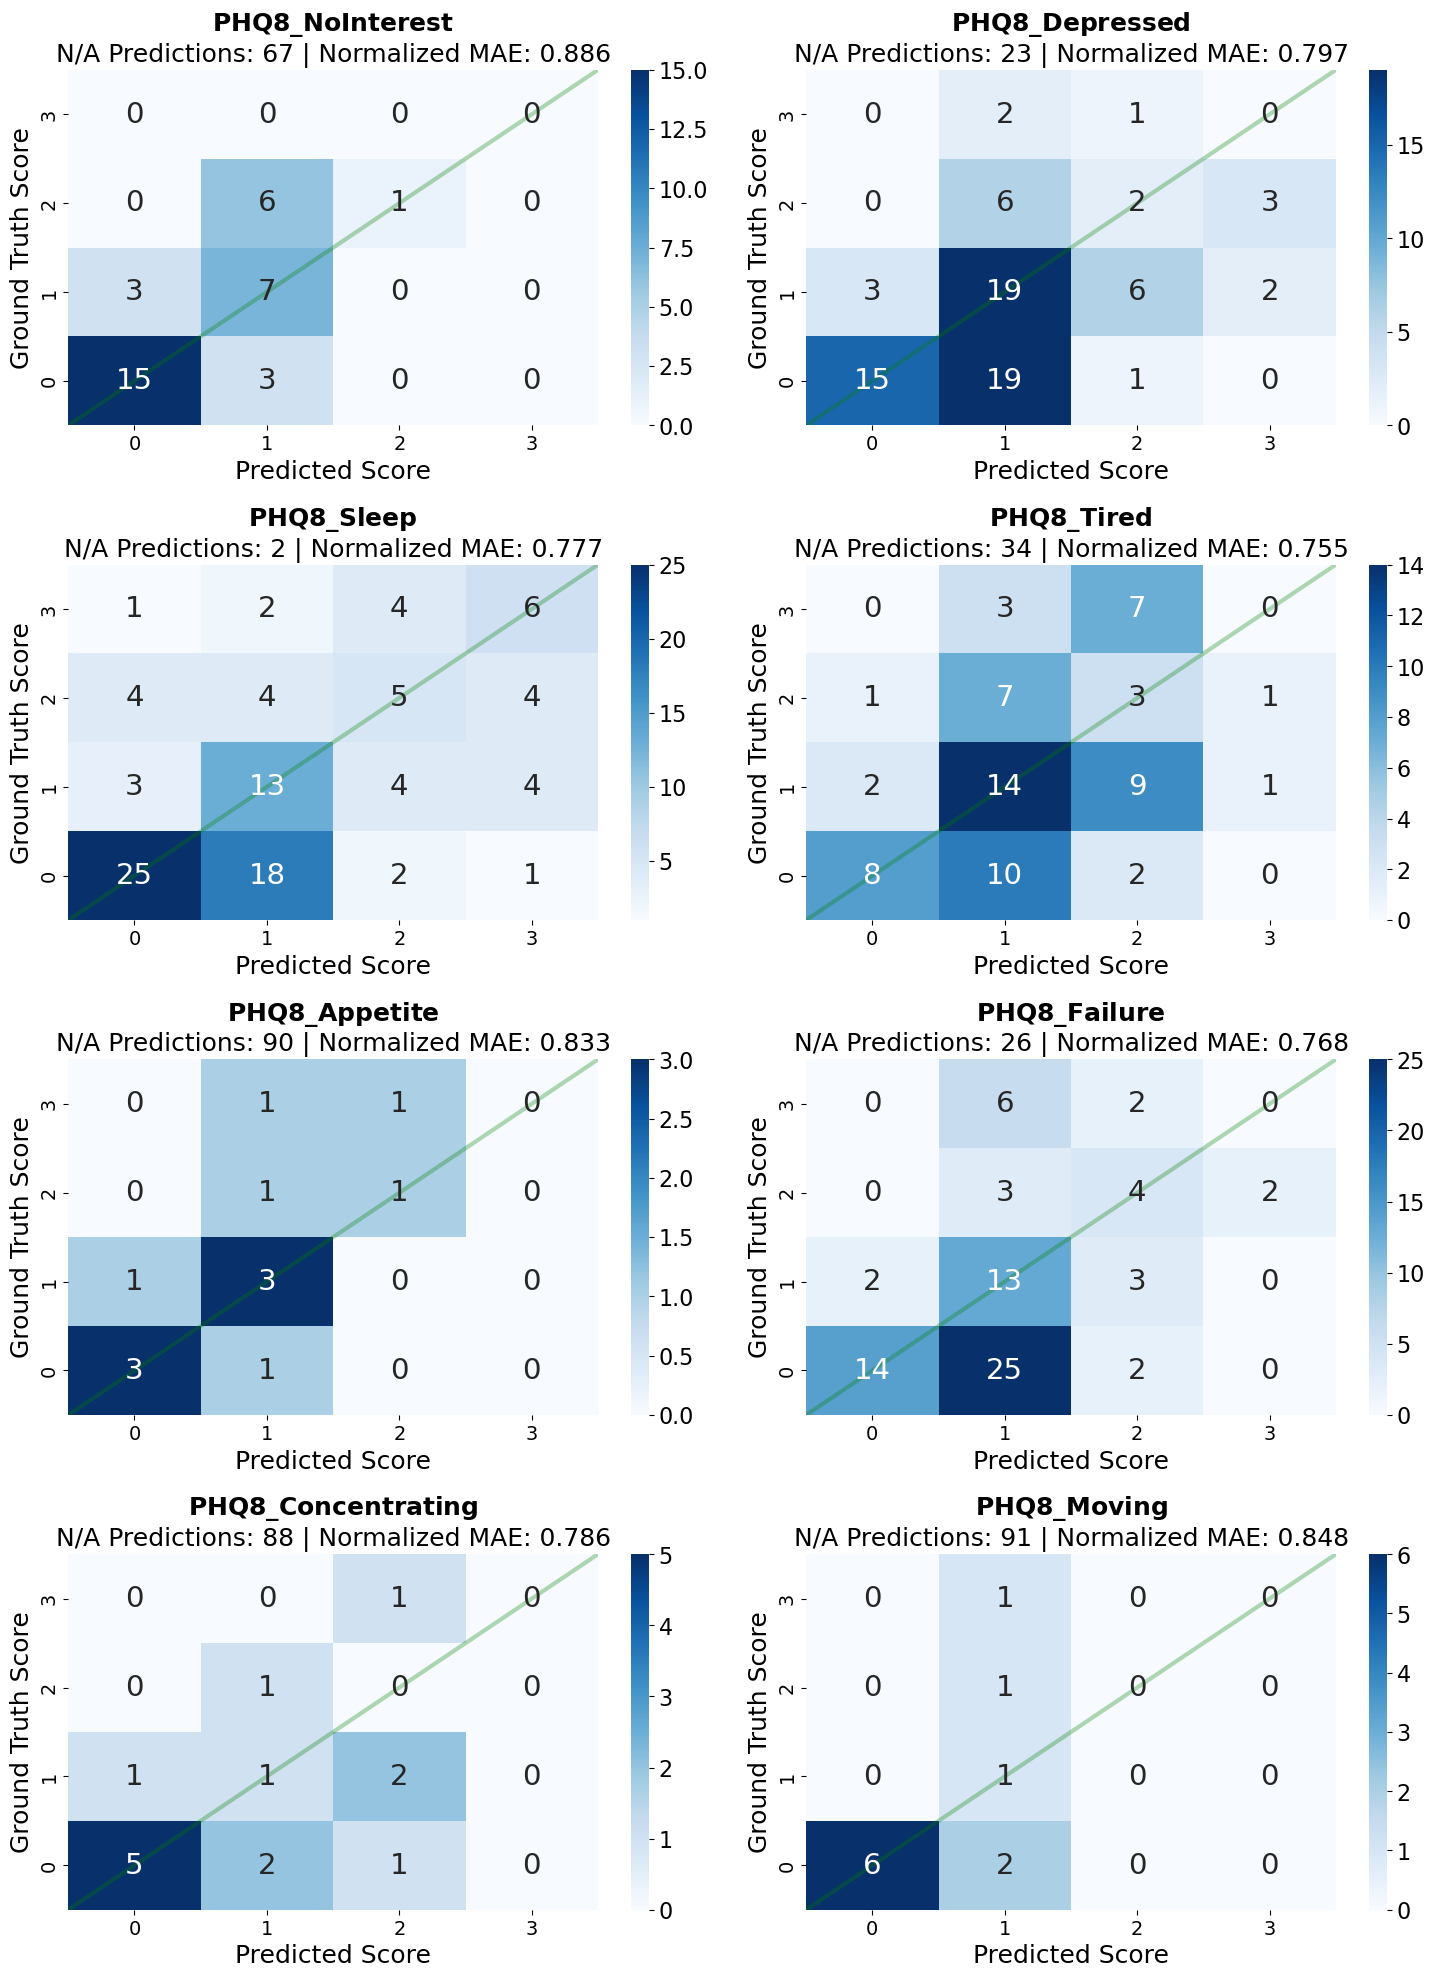

In [ ]:
def load_jsonl(file_path):
    """
    Loads the jsonl file

    Parameters
    ----------
    file_path : string
        The path to the jsonl file

    Returns
    -------
    list
        A list of dictionaries, where each dictionary represents 
        a JSON object from a line in the JSONL file
    """
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def load_ground_truth(csv_file1, csv_file2):
    """
    Loads and combines two CSV files containing ground truth data

    Parameters
    ----------
    csv_file1 : string
        Path to the first CSV file
    csv_file2 : string
        Path to the second CSV file

    Returns
    -------
    pandas dataframe
        A combined dataframe containing data from both CSV files
    """
    df1 = pd.read_csv(csv_file1)
    df2 = pd.read_csv(csv_file2)
    # Combine the csv files together instead of switching back and forth for participants
    combined_df = pd.concat([df1, df2], ignore_index=True)
    return combined_df

predicted_data = load_jsonl(r"/data/users2/agreene46/ai-psychiatrist/analysis_output/embedding_results_analysis.jsonl")
ground_truth_df = load_ground_truth(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv", r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")

# PHQ8 question names
phq8_questions = [
    'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
    'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
]

def extract_scores_for_question(predicted_data, ground_truth_df, question):
    """
    Grabs predicted and ground truth scores for a given PHQ8 question

    Parameters
    ----------
    predicted_data : list
        List of dictionaries containing predicted scores for participants
    ground_truth_df : pandas dataframe
        DataFrame containing ground truth scores with participant IDs
    question : string
        Name of the PHQ8 question to extract scores for

    Returns
    -------
    tuple
        A tuple containing:
        - predicted_scores (list): List of predicted scores as integers
        - ground_truth_scores (list): List of ground truth scores
        - participant_ids (list): List of participant IDs for matched entries
        - na_count (int): Number of entries with N/A predicted scores
    """

    predicted_scores = []
    ground_truth_scores = []
    participant_ids = []
    na_count = 0
    
    for entry in predicted_data:
        participant_id = entry['participant_id']
        
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        
        if not gt_row.empty:
            if question in entry:
                question_data = entry[question]
                score = question_data.get('score', 'N/A')
                
                if score == "N/A":
                    na_count += 1
                    continue
                else:
                    pred_score = int(score)
            else:
                na_count += 1
                continue
            
            # Get ground truth score
            gt_score = gt_row[question].iloc[0]
            
            predicted_scores.append(pred_score)
            ground_truth_scores.append(gt_score)
            participant_ids.append(participant_id)
    
    return predicted_scores, ground_truth_scores, participant_ids, na_count

def create_heatmap_with_na(predicted_scores, ground_truth_scores, question_name, na_count):
    """
    Creates a confusion matrix and calculates accuracy metrics for predicted vs ground truth scores

    Parameters
    ----------
    predicted_scores : list
        List of predicted scores as integers
    ground_truth_scores : list
        List of ground truth scores as integers
    question_name : string
        Name of the question (used for labeling)
    na_count : int
        Number of N/A predictions for this question

    Returns
    -------
    tuple
        A tuple containing:
        - cm (numpy.ndarray): Confusion matrix for scores 0-3
        - na_count (int): Number of N/A predictions
        - accuracy_available (float): Normalized accuracy (1 - normalized MAE)
    """
    # Create confusion matrix
    cm = confusion_matrix(ground_truth_scores, predicted_scores, labels=[0, 1, 2, 3])
    
    # Calculate metrics for title
    predicted_array = np.array(predicted_scores)
    ground_truth_array = np.array(ground_truth_scores)
    absolute_differences = np.abs(predicted_array - ground_truth_array)
    avg_absolute_diff = np.mean(absolute_differences)
    accuracy_available = 1 - (avg_absolute_diff / 3)
    
    return cm, na_count, accuracy_available

# Single figure
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

# Create heatmaps for all PHQ8 questions
for i, question in enumerate(phq8_questions):
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    
    cm, na_count, accuracy_available = create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)
    
    # Create heatmap on the subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[0, 1, 2, 3], 
                yticklabels=[0, 1, 2, 3],
                ax=axes[i], annot_kws={'size': 21})
    cbar = axes[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].set_xlabel('Predicted Score', fontsize=18)
    axes[i].set_ylabel('Ground Truth Score', fontsize=18)
    underscore_escaped = question.replace('_', r'\_')
    axes[i].set_title(f'$\\bf{{{underscore_escaped}}}$\nN/A Predictions: {na_count} | Normalized MAE: {accuracy_available:.3f}', 
                    fontsize=18)
    # Flip y axis so 0 is at bottom
    axes[i].invert_yaxis()
    # Correct prediction line
    axes[i].plot([-0.5, 4.5], [-0.5, 4.5], 'g-', linewidth=3, alpha=0.3)
    
    # Print statistics
    total_participants_with_gt = len(predicted_scores) + na_count
    percent_not_na = (total_participants_with_gt - na_count) / total_participants_with_gt
    overall_accuracy = accuracy_available * percent_not_na
    
    print(f"{question}:")
    print(f"  Absolute Average Difference: {np.mean(np.abs(np.array(predicted_scores) - np.array(ground_truth_scores))):.3f}")
    print(f"  Number of N/A Questions: {na_count}")
    print(f"  Accuracy on Available Questions: {accuracy_available:.3f}")
    print(f"  Overall Accuracy: {overall_accuracy:.3f}")
    print("-" * 50)


plt.tight_layout(pad=1.5)
plt.show()

# Create heatmaps for all PHQ8 questions
for question in phq8_questions:
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)